# Analyzing Cities: A Case Study of Singapore with comparisons between Singapore and New York   
### Final Project: Data Science Professional Certificate by IBM
__Michael W.D. Kurz__

## Table of Contents <a name="ToC"></a>    
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>     
Return to [Table of Contents](#ToC)

As cities’ around the world grow larger it becomes increasingly important to understand their internal structure as well as the similarities and differences between cities. The analysis presented in this report focuses on Singapore and New York City. These cities present an interesting case study for a preliminary analysis as they both are major financial, commercial, and cultural hubs with large, diverse populations. However, the two cities are also situated in culturally significantly different regional environments.    

For Singapore and New York City, I am using DBSCAN to find clusters of similar neighborhoods in Singapore. For this analysis, I am defining similarity in terms of the types and number of amenities in the neighborhood. Thus, I describe each neighborhood as a vector of the amenities within them. The analysis in this report is similar to the analysis of U.S. cities presented in (Preotiuc-Pietro, Cranshaw, & Yano, 2013).    

I augment this by demographic data on the residents of each neighborhood to gain a better understanding of which demographic groups reside most commonly in which kind of neighborhood. I will investigate whether similarity in terms of amenities correlates with similarity in terms of the demographic characteristics of residents.    

For each of the two cities, Singapore and New York, I obtain the spatial location of neighborhoods form free database available online, use the location data to download information for venues located in each neighborhood through the Foursquare API, and finally use the so-called DBSCAN algorithm to find clusters of similar neighborhoods with each of the cities. After having obtained clusters for each city I use agglomerative clustering applied to the city neighborhood clusters to create a hierarchy of cluster similarities that allows investigating similarities of clusters across the two cities.     

Identifying neighborhoods that are like each other in terms of amenities and which demographic groups typically reside in them can help urban planners/city planners to make more informed decisions. It may also help the proprietors of restaurants, bars, etc. to make informed decisions about the location of new venues. Additionally, the results can help residents that need to relocate from one part of the city to another to find neighborhoods that are like the one they currently live in or to select a neighborhood with similar amenities.

## Data <a name="data"></a>    
Return to [Table of Contents](#ToC)

___Neighborhood location data New York City:___  
* Spatial coordiates of New York City neighborhoods used in this notebook can be downloaded [here](https://cocl.us/new_york_dataset) (alternatively [here](https://geo.nyu.edu/catalog/nyu_2451_34572)). 
    
___Neighborhood data and demographic data Singapore:___
* Spatial coordiates of Singapore neighborhoods used in this notebook can be downloaded [here](https://geo.data.gov.sg/mp14-subzone-web-pl/2014/12/05/shp/mp14-subzone-web-pl.zip)
* The socio-demographic data for Singapore used in this notebook can be downloaded [here](https://data.gov.sg/dataset/resident-population-by-planning-area-subzone-age-group-and-sex-2015?resource_id=68775b41-3025-4763-970d-f479652e8b05) and [here](https://data.gov.sg/dataset/resident-population-by-planning-area-subzone-and-type-of-dwelling-2015?resource_id=2719aca1-6b37-4f8b-ac3f-a866d32df7c6)
     
___Amenities/venues data:___
* Data regarding available venues in Singapore and New York can be downloaded via the Foursquare API (requires reisgtration).

### Singapore: Data Collection and preparation    
In the following I will load and prepare the data needed for the clustering of Singapore's neighborhoods. The analysis of New York City will follow along the same lines. Code elements that will be needed for pre-processing both cities' data will be collected in functions to avoid dublicate code as much as possible. I also load most necessary libraries.

In [1]:
import pandas as pd # use dataframes in Pyhton, read .csv-files etc.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import numpy as np

import geopandas as gpd # use shapefiles in Python
from pyproj import Proj, transform # change map projection
import folium # Libarary that contains a detailed world map and the ability to zoom in down to the city level
from geopy.geocoders import Nominatim # reverse geocoder API to get coordinates for addresses/cites, etc.

import json # read JSON files
import requests # call URLs

import matplotlib.pyplot as plt # data visualization
import matplotlib.cm as cm
import matplotlib.colors as colors

I use a shapefile of Singapore that contains the boundaries of a sub-zones. The shapefile is available under an open data license [from a website of the government of Singapore](https://geo.data.gov.sg/mp14-subzone-web-pl/2014/12/05/shp/mp14-subzone-web-pl.zip).     
The government of Singapore defines sub-zones as follows: _'Subzones are divisions within a planning area which are usually centred around a focal point such as neighbourhood centre or activity node.'_    

I use the file 'Master Plan 2014 Subzone Boundary (Web)'. The master plan is a medium term development plan for a period of 10-15 years.

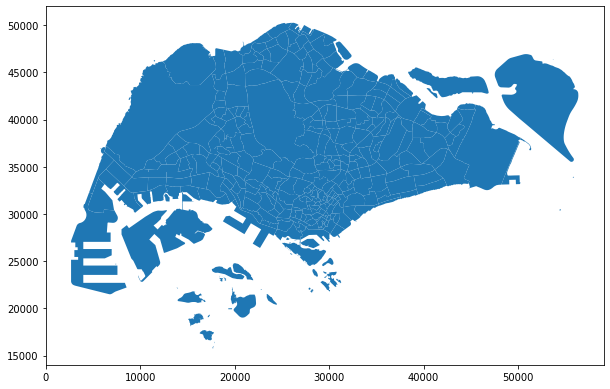

In [2]:
pathSing_shape = r'C:\Users\michael.kurz\Documents\Git_projects\Singapore_Urban_Form\Data\master-plan-2014-subzone-boundary-web-shp\MP14_SUBZONE_WEB_PL.shp'
singaporeShape = gpd.read_file(pathSing_shape)
ax = singaporeShape.plot(figsize=(10,7))
plt.show()

Coordinates in the shapefile are not longitude and latitude. Since I will be needing longitude and latitude coordiantes later on to get data from Foursquare, I will have to change to transform the coordinates. To do so, I need to get the projection of the map defined by the shapefile first:

In [3]:
singaporeShape.crs

{'proj': 'tmerc',
 'lat_0': 1.366666666666667,
 'lon_0': 103.8333333333333,
 'k': 1,
 'x_0': 28001.642,
 'y_0': 38744.572,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': True}

The information in crs tells me how the map of Singapore is projected. In this case a transverse mercator projection (tmerc) centered on 1.367°E 103.83°N (lat_0, lon_0). x_0,y_0 are the corresponding x,y coordinates of the center point of the map. Units in the map are meters. I can now extract the x,y coordinates of the geometric center point of each neighborhood polygon (its centroid) from the shapefile and use the information about way the map in the shapefiel is projected to convert the the x,y coordinates of each point to longitude and latitude coordinates.

In [4]:
singaporeDf = pd.DataFrame(columns=['SubZone_Code', 'SubZone_Name','Region_Code', 'Region_Name', 'SubZoneArea', 'latitude', 'longitude', 'x', 'y']) 

projection_string = "+proj=tmerc +lat_0=1.366666666666667 +lon_0=103.8333333333333 +k=1 +x_0=28001.642 +y_0=38744.572 +datum=WGS84 +units=m +no_defs"
p = Proj(projection_string)

for index,row in singaporeShape.iterrows():
    lng, lat = p(row.geometry.centroid.x,row.geometry.centroid.y, inverse=True)
    singaporeDf.loc[index] = [row.SUBZONE_C, row.SUBZONE_N.lower(), row.REGION_C, row.REGION_N, row.geometry.area/10**6, lat, lng, row.geometry.centroid.x,row.geometry.centroid.y]

singaporeDf.head()

,SubZone_Code,SubZone_Name,Region_Code,Region_Name,SubZoneArea,latitude,longitude,x,y
0,MSSZ01,marina south,CR,CENTRAL REGION,1.630379,1.280531,103.865629,31595.835746,29220.187377
1,OTSZ01,pearl's hill,CR,CENTRAL REGION,0.559816,1.285613,103.839420,28679.063482,29782.051966
2,SRSZ03,boat quay,CR,CENTRAL REGION,0.160807,1.287355,103.848189,29654.959448,29974.655356
3,BMSZ08,henderson hill,CR,CENTRAL REGION,0.595429,1.286985,103.822382,26782.826115,29933.765194
4,BMSZ03,redhill,CR,CENTRAL REGION,0.387429,1.287635,103.817162,26201.958019,30005.703511


The above dataframe now contains for each neighborhood (subzone): the region it belongs to, its area in sq-km, latitude and longitude coordinates, and x,y coordinates. I will use the latitude and longitude coordinates primarily to obtain the venues data from Foursquare. The area in sq-km can be used to inform the choice of a reasonable radius for the search query in Foursquare as the neighborhoods seem to vary in size.

In [5]:
singaporeDf.loc[:,'SubZone_Code':'SubZoneArea'].groupby('Region_Name').describe()

SubZoneArea                                          \
                        count      mean       std       min       25%   
Region_Name                                                             
CENTRAL REGION          134.0  1.017952  1.078615  0.039438  0.337352   
EAST REGION              30.0  3.765656  6.179367  0.494504  1.529476   
NORTH REGION             41.0  3.400137  6.138037  0.143138  1.281297   
NORTH-EAST REGION        48.0  2.834449  9.526342  0.316882  0.947999   
WEST REGION              70.0  3.673004  9.612790  0.380202  0.914210   

                                                  
                        50%       75%        max  
Region_Name                                       
CENTRAL REGION     0.593604  1.347130   7.601894  
EAST REGION        2.383305  3.407323  35.096029  
NORTH REGION       1.648630  2.553464  37.147854  
NORTH-EAST REGION  1.331205  1.757305  67.250563  
WEST REGION        1.504424  2.463417  69.748299

Most neighborhoods are located in the central region (134 neighborhoods), the second most in the west region (70 neighborhoods). There is a lot variation in neighborhood sizes. The average area of a neighborhood ranges approximately 1 sq-km (central region) to almost 3.8 sq-km (east region). Within each region the variation in the size of subzone areas is large.

In [6]:
import math

margin = 1.25 # increase area by 25% to account for neighborhoods not being circles and for the high variation in area sizes.
# I use a different search radius depending on the region of Singapore. Values are taken from the above table.

radiusDict = {'CENTRAL REGION': round(math.sqrt(1.017952*margin/math.pi),2)*1000, 
              'EAST REGION': round(math.sqrt(3.765656*margin/math.pi),2)*1000, 
              'NORTH REGION': round(math.sqrt(3.400137*margin/math.pi),2)*1000, 
              'NORTH-EAST REGION': round(math.sqrt(2.834449*margin/math.pi),2)*1000, 
              'WEST REGION': round(math.sqrt(3.673004*margin/math.pi),2)*1000}
radiusDict # dictonary containing the search radius in meters for subzones in each region.

{'CENTRAL REGION': 640.0,
 'EAST REGION': 1220.0,
 'NORTH REGION': 1160.0,
 'NORTH-EAST REGION': 1060.0,
 'WEST REGION': 1210.0}

Before continuing I will first attempt to plot the neighborhood locations on a folium map. For this purpose I need the coordinates of Singapores geographocal center.

In [7]:
# Since I'll be needing this again later on, I collect the code in a function
def GetCityCoords(address, agent):
    geolocator = Nominatim(user_agent = agent)
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return([latitude, longitude])

In [8]:
singapore_coords = GetCityCoords('Singapore', 'Singapore_App')
print('The geographical cooridnates of Singapore are Latitude: {}, Longitude: {}.'.format(singapore_coords[0],singapore_coords[1]))

The geographical cooridnates of Singapore are Latitude: 1.357107, Longitude: 103.8194992.


In [9]:
# To render the folium map I use the default OpenStreetMaps tile
mySingapore_map = folium.Map(location=singapore_coords, zoom_start=11, control_scale=True, tiles='OpenStreetMap') 

# I use a different color for neighborhoods in each region
pointColor = {'CENTRAL REGION': '#172CE6', 'EAST REGION': '#FFFF00', 'NORTH REGION': '#FF0000' , 'NORTH-EAST REGION': '#00FF09', 'WEST REGION': '#00F7FF'}

for lat, lng, subzone, region in zip(singaporeDf['latitude'], singaporeDf['longitude'], singaporeDf['SubZone_Name'], singaporeDf['Region_Name']):
    label = '{}, {}'.format(subzone, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color =  pointColor[region],
        fill = True,
        fill_color = pointColor[region],
        fill_opacity = 0.7,
        parse_html = False).add_to(mySingapore_map)


# Render interactive map including neighborhood locations:
mySingapore_map

#### Singapore socio-demographic data
For each sub-zone I want to get some demographic data on the sub-zone's residents. Specifically, I want to get the following information for each sub-zone: number of residents, age structure of residents, most common types of dwelling, ethnicity.

In [10]:
pathDataFile = r'C:\Users\michael.kurz\Documents\Git_projects\Singapore_Urban_Form\Data\Demographic_Data.xlsx'
hhDF = pd.read_excel(pathDataFile)
hhDF.SubZone_Name = hhDF.SubZone_Name.str.lower()
hhDF.head()

,SubZone_Name,Resident_Population,Age_0-4,Age_5-9,Age_10-14,Age_15-19,Age_20-24,Age_25-29,Age_30-34,Age_35-39,Age_40-44,Age_45-49,Age_50-54,Age_55-59,Age_60-64,Age_65-69,Age_70-74,Age_75-79,Age_80-84,Age_85 & Over,HDB_1-2_Room,HDB_3-Room,HDB_4-Room,HDB_5-Room_Exec,Condo_Other,Landed_Properties,Other_dwelling,Chinese,Malaya,Indians,Other_ethnicity
0,ang mo kio town centre,5020,260,280,320,280,260,310,370,420,490,420,350,320,280,270,160,120,60,50,3250,0,460,730,2060,1730,0,4260,210,360,190
1,cheng san,29770,1290,1180,1290,1400,1570,1830,2490,2490,2460,2220,2320,2290,2320,1920,1070,790,480,370,29610,840,14740,8690,5350,0,0,24660,2140,2380,600
2,chong boon,27900,910,1100,1180,1370,1520,1800,1980,2100,2040,2060,2270,2260,2250,1950,1290,920,540,380,27670,1840,13500,8810,3520,0,0,22910,1950,2400,630
3,kebun bahru,23910,780,1010,1080,1240,1380,1490,1570,1730,1860,1860,1940,1890,1800,1610,1010,810,530,330,22460,1920,11750,6460,2320,0,1170,19210,2200,1910,590
4,sembawang hills,6890,200,360,460,550,550,450,310,320,500,550,590,520,430,400,260,190,140,130,0,0,0,0,0,160,6660,6080,100,500,220


To make the data easier to work with I consolodate some of the coloumns.

In [11]:
singapore_popDf = pd.DataFrame()

singapore_popDf['SubZone_Name'] = hhDF['SubZone_Name']

singapore_popDf['Resident_Population'] = hhDF['Resident_Population']

singapore_popDf['Age_(0-19)'] = (hhDF['Age_0-4'] + hhDF['Age_5-9'] + hhDF['Age_10-14'] + hhDF['Age_15-19'])/hhDF['Resident_Population']
singapore_popDf['Age_(20-34)'] = (hhDF['Age_20-24'] + hhDF['Age_25-29'] + hhDF['Age_30-34'])/hhDF['Resident_Population']
singapore_popDf['Age_(35-49)'] = (hhDF['Age_35-39'] + hhDF['Age_40-44'] + hhDF['Age_45-49'])/hhDF['Resident_Population']
singapore_popDf['Age_(50-64)'] = (hhDF['Age_50-54'] + hhDF['Age_55-59'] + hhDF['Age_60-64'])/hhDF['Resident_Population']
singapore_popDf['Age_(65-)'] = (hhDF['Age_65-69'] + hhDF['Age_70-74'] + hhDF['Age_75-79'] + hhDF['Age_80-84'] + hhDF['Age_85 & Over'])/hhDF['Resident_Population']

singapore_popDf['HDB_1-2_rooms'] = hhDF['HDB_1-2_Room']/hhDF['Resident_Population']
singapore_popDf['HDB_3_rooms'] = hhDF['HDB_3-Room']/hhDF['Resident_Population']
singapore_popDf['HDB_4_rooms'] = hhDF['HDB_4-Room']/hhDF['Resident_Population']
singapore_popDf['HDB_5_rooms'] = hhDF['HDB_5-Room_Exec']/hhDF['Resident_Population']
singapore_popDf['Condos'] = hhDF['Condo_Other']/hhDF['Resident_Population']
singapore_popDf['Other_dwelling'] = (hhDF['Landed_Properties'] + hhDF['Other_dwelling'])/hhDF['Resident_Population']

singapore_popDf['Chinese'] = hhDF['Chinese']/hhDF['Resident_Population']
singapore_popDf['Malaya'] = hhDF['Malaya']/hhDF['Resident_Population']
singapore_popDf['Indian'] = hhDF['Indians']/hhDF['Resident_Population']
singapore_popDf['Other_Ethnicity'] = hhDF['Other_ethnicity']/hhDF['Resident_Population']

singapore_popDf.fillna(0, inplace=True)

singapore_popDf = singapore_popDf.merge(singaporeDf, how='inner', on='SubZone_Name')
singapore_popDf.head()

,SubZone_Name,Resident_Population,Age_(0-19),Age_(20-34),Age_(35-49),Age_(50-64),Age_(65-),HDB_1-2_rooms,HDB_3_rooms,HDB_4_rooms,HDB_5_rooms,Condos,Other_dwelling,Chinese,Malaya,Indian,Other_Ethnicity,SubZone_Code,Region_Code,Region_Name,SubZoneArea,latitude,longitude,x,y
0,ang mo kio town centre,5020,0.227092,0.187251,0.264940,0.189243,0.131474,0.647410,0.000000,0.091633,0.145418,0.410359,0.344622,0.848606,0.041833,0.071713,0.037849,AMSZ01,NER,NORTH-EAST REGION,0.316882,1.372770,103.846813,29501.765925,39419.404931
1,cheng san,29770,0.173329,0.197850,0.240846,0.232785,0.155526,0.994625,0.028216,0.495129,0.291905,0.179711,0.000000,0.828351,0.071884,0.079946,0.020155,AMSZ02,NER,NORTH-EAST REGION,0.955710,1.372715,103.854095,30312.192396,39413.347824
2,chong boon,27900,0.163441,0.189964,0.222222,0.243011,0.182079,0.991756,0.065950,0.483871,0.315771,0.126165,0.000000,0.821147,0.069892,0.086022,0.022581,AMSZ03,NER,NORTH-EAST REGION,1.078622,1.364265,103.855653,30485.510968,38478.993077
3,kebun bahru,23910,0.171895,0.185696,0.227938,0.235466,0.179423,0.939356,0.080301,0.491426,0.270180,0.097031,0.048934,0.803430,0.092012,0.079883,0.024676,AMSZ06,NER,NORTH-EAST REGION,1.046417,1.373467,103.839610,28700.167402,39496.506105
4,sembawang hills,6890,0.227866,0.190131,0.198839,0.223512,0.162554,0.000000,0.000000,0.000000,0.000000,0.000000,0.989840,0.882438,0.014514,0.072569,0.031930,AMSZ07,NER,NORTH-EAST REGION,0.894516,1.374715,103.830766,27715.923623,39634.529022


In [91]:
demo_sing_region = singapore_popDf.loc[:,'Resident_Population':'SubZoneArea'].groupby('Region_Name')
demo_sing_region.describe()

Resident_Population                                          \
                                count          mean           std  min    25%   
Region_Name                                                                     
CENTRAL REGION                  134.0   7014.701493   8922.988532  0.0  240.0   
EAST REGION                      30.0  23114.666667  33120.380821  0.0   20.0   
NORTH REGION                     41.0  12972.682927  21266.907512  0.0   20.0   
NORTH-EAST REGION                48.0  17386.458333  16992.515435  0.0   52.5   
WEST REGION                      70.0  12900.000000  16560.591164  0.0   10.0   

                                              Age_(0-19)                      \
                       50%      75%       max      count      mean       std   
Region_Name                                                                    
CENTRAL REGION      3230.0  10917.5   41710.0      134.0  0.157641  0.081560   
EAST REGION         4955.0  37912.5  138500.0       30.0  0.148782  0.113344   
NORTH REGION         900.0  26860.0   95510.0       41.0  0.125343  0.121221   
NORTH-EAST REGION  15120.0  28010.0   59860.0       48.0  0.163213  0.107007   
WEST REGION         5640.0  21267.5   70890.0       70.0  0.126585  0.113019   

                                                               Age_(20-34)  \
                   min       25%       50%       75%       max       count   
Region_Name                                                                  
CENTRAL REGION     0.0  0.134394  0.179103  0.213203  0.312500       134.0   
EAST REGION        0.0  0.000000  0.193221  0.224448  0.373563        30.0   
NORTH REGION       0.0  0.000000  0.181818  0.250000  0.310105        41.0   
NORTH-EAST REGION  0.0  0.000000  0.195901  0.230116  0.303112        48.0   
WEST REGION        0.0  0.000000  0.189655  0.232981  0.279907        70.0   

                                                                          \
                       mean       std  min       25%       50%       75%   
Region_Name                                                                
CENTRAL REGION     0.155683  0.086082  0.0  0.153846  0.174978  0.190078   
EAST REGION        0.134341  0.099193  0.0  0.000000  0.180557  0.212891   
NORTH REGION       0.118867  0.113609  0.0  0.000000  0.170163  0.219768   
NORTH-EAST REGION  0.153663  0.101658  0.0  0.000000  0.195912  0.217320   
WEST REGION        0.124041  0.109375  0.0  0.000000  0.189336  0.222878   

                            Age_(35-49)                                     \
                        max       count      mean       std  min       25%   
Region_Name                                                                  
CENTRAL REGION     0.694444       134.0  0.217677  0.110853  0.0  0.208346   
EAST REGION        0.237466        30.0  0.161283  0.117605  0.0  0.000000   
NORTH REGION       0.274781        41.0  0.128613  0.119627  0.0  0.000000   
NORTH-EAST REGION  0.308525        48.0  0.171985  0.110231  0.0  0.000000   
WEST REGION        0.277778        70.0  0.136094  0.119774  0.0  0.000000   

                                                Age_(50-64)            \
                        50%       75%       max       count      mean   
Region_Name                                                             
CENTRAL REGION     0.239711  0.270233  0.454545       134.0  0.181257   
EAST REGION        0.210577  0.231687  0.327586        30.0  0.151848   
NORTH REGION       0.193299  0.237398  0.281087        41.0  0.116172   
NORTH-EAST REGION  0.212117  0.241574  0.346154        48.0  0.156376   
WEST REGION        0.220992  0.235354  0.297329        70.0  0.125592   

                                                                          \
                        std  min       25%       50%       75%       max   
Region_Name                                                                
CENTRAL REGION     0.086832  0.0  0.176549  0.210331  0.

#### Singapore Venues data    
Using the neighborhood location data previously obatined, I now turn to obtaining the venues data from Foursqure.   

I store my log in credentials for the Forsquare API in a JSON file on my local machine and load the details in a dictonary. In this way hand them to the API without revealing my credentials when sharing the notebook. Note that to run the notebook it is necessary to load own credentials.

In [13]:
with open(r'C:\Users\michael.kurz\Documents\Git_projects\Foursquare_Credentials.json') as f:
    data = json.load(f)
    fSqure_credentials = {'CLIENT_ID':data['CLIENT_ID'],'CLIENT_SECRET':data['CLIENT_SECRET'],'VERSION':data['VERSION']}

In [15]:
venues_list = []
myLimit = 100 # this is the max allowed by the Foursquare API


# loop through all subzones in the dataset and get Foursquare data for each one
for subzoneCode, region, subzoneName, lat, lng in zip(singaporeDf['SubZone_Code'], singaporeDf['Region_Name'], singaporeDf['SubZone_Name'], singaporeDf['latitude'], singaporeDf['longitude']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    fSqure_credentials['CLIENT_ID'],
    fSqure_credentials['CLIENT_SECRET'],
    fSqure_credentials['VERSION'],
    lat,
    lng,
    radiusDict[region],
    myLimit)
    results = requests.get(url).json()
    loc_venue = results['response']['groups'][0]['items']
    venues_list.append([(subzoneCode,region, lat, lng, subzoneName, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],v['venue']['categories'][0]['name'],v['venue']['categories'][0]['id']) for v in loc_venue])

singapore_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
singapore_venues.columns = ['SubZone_Code', 'Region_Name', 
                  'latitude', 
                  'longitude',
                  'SubZone_Name',
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category',
                  'Venue_Category_ID']

singapore_venues.head()

,SubZone_Code,Region_Name,latitude,longitude,SubZone_Name,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_Category_ID
0,MSSZ01,CENTRAL REGION,1.280531,103.865629,marina south,Supertree Grove,1.282000,103.864134,Garden,4bf58dd8d48988d15a941735
1,MSSZ01,CENTRAL REGION,1.280531,103.865629,marina south,OCBC Skyway,1.282193,103.864175,Scenic Lookout,4bf58dd8d48988d165941735
2,MSSZ01,CENTRAL REGION,1.280531,103.865629,marina south,Far East Organization Children's Garden,1.283125,103.867104,Playground,4bf58dd8d48988d1e7941735
3,MSSZ01,CENTRAL REGION,1.280531,103.865629,marina south,Cloud Forest,1.283798,103.865428,Botanical Garden,52e81612bcbc57f1066b7a22
4,MSSZ01,CENTRAL REGION,1.280531,103.865629,marina south,Gardens by the Bay,1.282417,103.862594,Garden,4bf58dd8d48988d15a941735


In [16]:
print('The dataframe has {} rows and {} columns.'.format(singapore_venues.shape[0],singapore_venues.shape[1]))
print('There are {} unique venue categories and {} unique venues in the dataframe.'.format(len(singapore_venues['Venue_Category'].unique()),len(singapore_venues['Venue'].unique())))

The dataframe has 14682 rows and 10 columns.
There are 376 unique venue categories and 6009 unique venues in the dataframe.


The number unique venue categories seems excessive with many cateories being very simialr (see the overview of venue categories [here](https://developer.foursquare.com/docs/build-with-foursquare/categories/)). However, only using primary categories would leave me with only 9 categories which seems too coarse. Therefore, I consolodate venue categories following the below scheme:

In [17]:
venue_lib = {'Movie Theater':['56aa371be4b08b9a8d5734de', '4bf58dd8d48988d17e941735','4bf58dd8d48988d180941735', 
                              '4bf58dd8d48988d17f941735'],
            'Museum':['4bf58dd8d48988d181941735','4bf58dd8d48988d18f941735','559acbe0498e472f1a53fa23',
                     '4bf58dd8d48988d190941735', '4bf58dd8d48988d192941735', '4bf58dd8d48988d191941735',
                     '5744ccdfe4b0c0459246b4d9'],
            'Music Venue':['4bf58dd8d48988d1e5931735','4bf58dd8d48988d1e7931735','4bf58dd8d48988d1e8931735',
                          '4bf58dd8d48988d1e9931735'],
            'Performing Arts Venue':['4bf58dd8d48988d1f2931735', '4bf58dd8d48988d134941735',
                                    '4bf58dd8d48988d135941735','4bf58dd8d48988d136941735', '4bf58dd8d48988d137941735','4bf58dd8d48988d1ac941735'],
            'Sports': ['4bf58dd8d48988d184941735','4bf58dd8d48988d18c941735','4bf58dd8d48988d18b941735',
                       '4bf58dd8d48988d18a941735','4bf58dd8d48988d189941735','4bf58dd8d48988d185941735',
                       '56aa371be4b08b9a8d573556','4bf58dd8d48988d188941735','4e39a891bd410d7aed40cbc2',
                       '4bf58dd8d48988d187941735', '4bf58dd8d48988d1b4941735','4bf58dd8d48988d1bb941735',
                       '4bf58dd8d48988d1ba941735','4bf58dd8d48988d1b9941735','4bf58dd8d48988d1b8941735','4bf58dd8d48988d1b5941735',
                       '4bf58dd8d48988d1b7941735', '4e39a9cebd410d7aed40cbc4','4bf58dd8d48988d1b6941735'],
            'Theme Park':['4bf58dd8d48988d182941735','5109983191d435c0d71c2bb1','4bf58dd8d48988d193941735','4bf58dd8d48988d17b941735',
                         '58daa1558bbb0b01f18ec1fd'],
            'College & University':['4d4b7105d754a06372d81259','4bf58dd8d48988d198941735','4bf58dd8d48988d199941735',
                                   '4bf58dd8d48988d19a941735','4bf58dd8d48988d19e941735','4bf58dd8d48988d19d941735',
                                   '4bf58dd8d48988d19c941735','4bf58dd8d48988d19b941735','4bf58dd8d48988d19f941735',
                                   '4bf58dd8d48988d197941735', '4bf58dd8d48988d1af941735','4bf58dd8d48988d1b1941735',
                                   '4bf58dd8d48988d1a1941735', '4bf58dd8d48988d1a0941735','4bf58dd8d48988d1b2941735',
                                   '4bf58dd8d48988d1a5941735','4bf58dd8d48988d1a7941735','4bf58dd8d48988d1aa941735',
                                   '4bf58dd8d48988d1a9941735','4bf58dd8d48988d1a3941735','4bf58dd8d48988d1a2941735',
                                   '4bf58dd8d48988d1b0941735', '4bf58dd8d48988d1a8941735','4bf58dd8d48988d1a6941735',
                                   '4bf58dd8d48988d1b3941735','4bf58dd8d48988d141941735','4bf58dd8d48988d1ab941735',
                                   '4bf58dd8d48988d1ad941735','4bf58dd8d48988d1ae941735','56aa371ce4b08b9a8d573570'],
            'Food General':['4d4b7105d754a06374d81259','52e81612bcbc57f1066b79f4','4bf58dd8d48988d128941735',
                           '4bf58dd8d48988d1c4941735'],
            'African Restaurant':['4bf58dd8d48988d1c8941735','4bf58dd8d48988d10a941735'],
            'American Restaurant':['4bf58dd8d48988d14e941735','4bf58dd8d48988d157941735'],
            'Chinese Restaurant':['4bf58dd8d48988d145941735','52af3a5e3cf9994f4e043bea','52af3a723cf9994f4e043bec',
                                 '52af3a7c3cf9994f4e043bed','58daa1558bbb0b01f18ec1d3','52af3a673cf9994f4e043beb',
                                 '52af3a903cf9994f4e043bee','4bf58dd8d48988d1f5931735','52af3a9f3cf9994f4e043bef',
                                 '52af3aaa3cf9994f4e043bf0','52af3ab53cf9994f4e043bf1','52af3abe3cf9994f4e043bf2',
                                 '52af3ac83cf9994f4e043bf3','52af3ad23cf9994f4e043bf4','52af3add3cf9994f4e043bf5',
                                 '52af3af23cf9994f4e043bf7','52af3ae63cf9994f4e043bf6','52af3afc3cf9994f4e043bf8',
                                 '52af3b053cf9994f4e043bf9','52af3b213cf9994f4e043bfa','52af3b293cf9994f4e043bfb',
                                 '52af3b343cf9994f4e043bfc','52af3b3b3cf9994f4e043bfd','52af3b463cf9994f4e043bfe',
                                 '52af3b633cf9994f4e043c01','52af3b513cf9994f4e043bff','52af3b593cf9994f4e043c00',
                                 '52af3b6e3cf9994f4e043c02','52af3b773cf9994f4e043c03','52af3b813cf9994f4e043c04',
                                 '52af3b893cf9994f4e043c05','52af3b913cf9994f4e043c06','52af3b9a3cf9994f4e043c07','52af3ba23cf9994f4e043c08'],
            'Japanese Restaurant':['4bf58dd8d48988d111941735','55a59bace4b013909087cb30','55a59bace4b013909087cb24',
                                  '55a59bace4b013909087cb15','55a59bace4b013909087cb27','55a59bace4b013909087cb2a'],
            'Coffee Shop':['4bf58dd8d48988d1e0931735','4bf58dd8d48988d16d941735'],
            'Dessert Shop':['52e81612bcbc57f1066b79f2','4bf58dd8d48988d1d0941735','4bf58dd8d48988d1bc941735',
                           '512e7cae91d4cbb4e5efe0af','4bf58dd8d48988d1c9941735','5744ccdfe4b0c0459246b4e2',
                           '52e81612bcbc57f1066b7a0a', '4bf58dd8d48988d148941735'],
            'Indian Restaurant':['4bf58dd8d48988d10f941735','54135bf5e4b08f3d2429dfe2','54135bf5e4b08f3d2429dfe3',
                                '54135bf5e4b08f3d2429dfdd','54135bf5e4b08f3d2429dfde'],
            'Jewish Restaurant':['52e81612bcbc57f1066b79fd','52e81612bcbc57f1066b79fc'],
            'Latin American Restaurant':['4bf58dd8d48988d1be941735','4bf58dd8d48988d152941735',
                                        '52939a8c3cf9994f4e043a35'],
            'Mexican Restaurant':['4bf58dd8d48988d1c1941735','4bf58dd8d48988d153941735','4bf58dd8d48988d151941735',
                                 '56aa371ae4b08b9a8d5734ba'],
            'Spanish Restaurant':['4bf58dd8d48988d150941735','4bf58dd8d48988d14d941735','4bf58dd8d48988d1db931735'],
            'Fried Chicken Joint':['4d4ae6fc7a7b7dea34424761','4bf58dd8d48988d14c941735'],
            'Bar':['4bf58dd8d48988d116941735','4bf58dd8d48988d155941735','52e81612bcbc57f1066b7a06','4bf58dd8d48988d116941735',
                  '52e81612bcbc57f1066b7a0d','56aa371ce4b08b9a8d57356c','4bf58dd8d48988d117941735','52e81612bcbc57f1066b7a0e',
                  '4bf58dd8d48988d11e941735','4bf58dd8d48988d118941735','4bf58dd8d48988d1d8941735','4bf58dd8d48988d119941735',
                  '4bf58dd8d48988d1d5941735','4bf58dd8d48988d120941735','4bf58dd8d48988d11b941735','4bf58dd8d48988d11c941735',
                  '4bf58dd8d48988d1d4941735','4bf58dd8d48988d11d941735','56aa371be4b08b9a8d57354d','4bf58dd8d48988d122941735',
                  '4bf58dd8d48988d123941735', '4bf58dd8d48988d121941735','52f2ab2ebcbc57f1066b8b41'],
            'Athletics & Sports':['4f4528bc4b90abdf24c9de85','52e81612bcbc57f1066b7a2b','4bf58dd8d48988d1e8941735',
                                 '4bf58dd8d48988d1e1941735','52e81612bcbc57f1066b7a2f','56aa371be4b08b9a8d57351a',
                                 '4f452cd44b9081a197eba860','56aa371be4b08b9a8d57352c','52e81612bcbc57f1066b7a2c',
                                 '4bf58dd8d48988d167941735','4bf58dd8d48988d168941735','4cce455aebf7b749d5e191f5',
                                 '52e81612bcbc57f1066b7a2e','4e39a956bd410d7aed40cbc3','4eb1bf013b7b6f98df247e07',
                                 '52e81612bcbc57f1066b7a44','52e81612bcbc57f1066b7a27'],
             'Gym':['4bf58dd8d48988d175941735','52f2ab2ebcbc57f1066b8b47','503289d391d4c4b30a586d6a','52f2ab2ebcbc57f1066b8b49',
                   '4bf58dd8d48988d105941735','52f2ab2ebcbc57f1066b8b48','4bf58dd8d48988d176941735','4bf58dd8d48988d101941735',
                   '58daa1558bbb0b01f18ec203','5744ccdfe4b0c0459246b4b2','4bf58dd8d48988d106941735','590a0744340a5803fd8508c3',
                   '4bf58dd8d48988d102941735','52e81612bcbc57f1066b7a2d','58daa1558bbb0b01f18ec1ae','4bf58dd8d48988d1ed941735'],
            'Golf':['4bf58dd8d48988d1e6941735','58daa1558bbb0b01f18ec1b0'],
            'Beach':['4bf58dd8d48988d1e2941735', '52e81612bcbc57f1066b7a30','4bf58dd8d48988d1e3941735','52e81612bcbc57f1066b7a12'],
            'Professional & Other Places':['4d4b7105d754a06375d81259', '4bf58dd8d48988d173941735','56aa371be4b08b9a8d5734cf',
                                          '56aa371be4b08b9a8d573517','52e81612bcbc57f1066b7a35','52e81612bcbc57f1066b7a34',
                                          '4bf58dd8d48988d1ff931735','4bf58dd8d48988d100941735','4e0e22f5a56208c4ea9a85a0',
                                          '52e81612bcbc57f1066b7a37','4bf58dd8d48988d171941735','56aa371be4b08b9a8d57356a','4eb1daf44b900d56c88a4600',
                                          '4f4534884b9074f6e4fb0174','4bf58dd8d48988d126941735','4bf58dd8d48988d12a941735',
                                          '4bf58dd8d48988d129941735','4bf58dd8d48988d12b941735','4bf58dd8d48988d12c951735',
                                          '4bf58dd8d48988d12c941735','4bf58dd8d48988d12d941735','4bf58dd8d48988d12e941735',
                                          '52e81612bcbc57f1066b7a38','56aa371be4b08b9a8d5734d7','5744ccdfe4b0c0459246b4d6',
                                          '4bf58dd8d48988d124941735','52e81612bcbc57f1066b7a3d','5032764e91d4c4b30a586d5a',
                                          '4bf58dd8d48988d127941735','5665ef1d498ec706735f0e59','54f4ba06498e2cf5561da814',
                                          '5665c7b9498e7d8a4f2c0f06','4bf58dd8d48988d174941735','4bf58dd8d48988d125941735',
                                          '58daa1548bbb0b01f18ec1a9','5310b8e5bcbc57f1066bcbf1','5032856091d4c4b30a586d63',
                                          '52f2ab2ebcbc57f1066b8b57','58daa1558bbb0b01f18ec1b2','52e81612bcbc57f1066b7a43',
                                          '58daa1558bbb0b01f18ec200','52e81612bcbc57f1066b7a42','52e81612bcbc57f1066b7a49',
                                          '52e81612bcbc57f1066b7a31','4cae28ecbf23941eb1190695','52e81612bcbc57f1066b7a36',
                                          '58daa1558bbb0b01f18ec1ac','56aa371be4b08b9a8d5734c5','4bf58dd8d48988d14b941735',
                                          '5453de49498eade8af355881','4bf58dd8d48988d1f4941735','56aa371be4b08b9a8d573523',
                                          '52f2ab2ebcbc57f1066b8b37','4f4531084b9074f6e4fb0101','56aa371be4b08b9a8d573552'],
            'Medical':['4bf58dd8d48988d104941735','52e81612bcbc57f1066b7a3b','52e81612bcbc57f1066b7a3c',
                      '52e81612bcbc57f1066b7a3a','4bf58dd8d48988d178941735','4bf58dd8d48988d177941735','4bf58dd8d48988d194941735',
                      '522e32fae4b09b556e370f19','4bf58dd8d48988d196941735','58daa1558bbb0b01f18ec1f7','56aa371be4b08b9a8d5734ff',
                      '4f4531b14b9074f6e4fb0103','52e81612bcbc57f1066b7a39','58daa1558bbb0b01f18ec1d0','5744ccdfe4b0c0459246b4af',
                      '56aa371be4b08b9a8d57351d','56aa371be4b08b9a8d573526','58daa1558bbb0b01f18ec206','4d954afda243a5684865b473',
                      '4bf58dd8d48988d10f951735'],
            'School':['4bf58dd8d48988d13b941735','4f4533804b9074f6e4fb0105','4bf58dd8d48988d13d941735','4f4533814b9074f6e4fb0106',
                     '4f4533814b9074f6e4fb0107','52e81612bcbc57f1066b7a45','52e81612bcbc57f1066b7a46'],
            'Spiritual Center':['52e81612bcbc57f1066b7a47','4bf58dd8d48988d131941735','52e81612bcbc57f1066b7a3e',
                               '58daa1558bbb0b01f18ec1eb','4bf58dd8d48988d132941735','56aa371be4b08b9a8d5734fc',
                               '52e81612bcbc57f1066b7a3f','5744ccdfe4b0c0459246b4ac','52e81612bcbc57f1066b7a40',
                               '4bf58dd8d48988d138941735','52e81612bcbc57f1066b7a41','4eb1d80a4b900d56c88a45ff',
                               '5bae9231bedf3950379f89c9','4bf58dd8d48988d139941735','4bf58dd8d48988d13a941735','56aa371be4b08b9a8d5734f6'],
            'Shop & Service':['4d4b7105d754a06378d81259','52f2ab2ebcbc57f1066b8b56','5267e446e4b0ec79466e48c4',
                             '4bf58dd8d48988d116951735','4bf58dd8d48988d127951735','52f2ab2ebcbc57f1066b8b43',
                             '4eb1c1623b7b52c0e1adc2ec','52f2ab2ebcbc57f1066b8b44','56aa371be4b08b9a8d5734d3',
                             '4bf58dd8d48988d124951735','52f2ab2ebcbc57f1066b8b32','4bf58dd8d48988d10a951735',
                             '56aa371be4b08b9a8d5734cb','52f2ab2ebcbc57f1066b8b40','52f2ab2ebcbc57f1066b8b42',
                             '4bf58dd8d48988d115951735','4bf58dd8d48988d1f1941735','4bf58dd8d48988d114951735',
                             '4bf58dd8d48988d11a951735','4eb1bdf03b7b55596b4a7491','4bf58dd8d48988d117951735',
                             '4f04ae1f2fb6e1c99f3db0ba','52f2ab2ebcbc57f1066b8b2a','52f2ab2ebcbc57f1066b8b2d',
                             '52f2ab2ebcbc57f1066b8b31','4bf58dd8d48988d103951735','4bf58dd8d48988d102951735',
                             '4bf58dd8d48988d104951735','4bf58dd8d48988d105951735','4bf58dd8d48988d109951735',
                             '4bf58dd8d48988d106951735','4bf58dd8d48988d107951735','4bf58dd8d48988d108951735',
                             '52f2ab2ebcbc57f1066b8b18','4d954b0ea243a5684a65b473','4bf58dd8d48988d10c951735',
                             '52f2ab2ebcbc57f1066b8b17','5032850891d4c4b30a586d62','5744ccdfe4b0c0459246b4be',
                             '4bf58dd8d48988d1f6941735','52dea92d3cf9994f4e043dbb','52f2ab2ebcbc57f1066b8b1a',
                             '5745c2e4498e11e7bccabdbd','52f2ab2ebcbc57f1066b8b1d','5032872391d4c4b30a586d64',
                             '4bf58dd8d48988d122951735','56aa371be4b08b9a8d573554','5454152e498ef71e2b9132c6',
                             '52f2ab2ebcbc57f1066b8b26','503287a291d4c4b30a586d65','52f2ab2ebcbc57f1066b8b3a',
                             '52f2ab2ebcbc57f1066b8b16','4bf58dd8d48988d1f7941735','56aa371be4b08b9a8d573505',
                             '4bf58dd8d48988d11b951735','4bf58dd8d48988d1f9941735','5370f356bcbc57f1066c94c2',
                             '4bf58dd8d48988d11d951735','4bf58dd8d48988d11e951735','5e18993feee47d000759b256',
                             '58daa1558bbb0b01f18ec1ca','4bf58dd8d48988d1fa941735','4bf58dd8d48988d10e951735',
                             '56aa371be4b08b9a8d573550','4bf58dd8d48988d1f5941735','4bf58dd8d48988d118951735',
                             '50aa9e744b90af0d42d5de0e','58daa1558bbb0b01f18ec1e8','4bf58dd8d48988d186941735',
                             '52f2ab2ebcbc57f1066b8b45','56aa371be4b08b9a8d573564','53e0feef498e5aac066fd8a9',
                             '52f2ab2ebcbc57f1066b8b46','58daa1558bbb0b01f18ec1e5','4bf58dd8d48988d119951735',
                             '52f2ab2ebcbc57f1066b8b24','52f2ab2ebcbc57f1066b8b1c','4bf58dd8d48988d1f8941735',
                             '55888a5a498e782e3303b43a','4bf58dd8d48988d18d941735','4eb1c0253b7b52c0e1adc2e9',
                             '4bf58dd8d48988d113951735','4bf58dd8d48988d128951735','52f2ab2ebcbc57f1066b8b19',
                             '4bf58dd8d48988d112951735','54541900498ea6ccd0202697','52f2ab2ebcbc57f1066b8b2c',
                             '4bf58dd8d48988d1fb941735','545419b1498ea6ccd0202f58','50aaa5234b90af0d42d5de12',
                             '52f2ab2ebcbc57f1066b8b36','58daa1558bbb0b01f18ec1f1','4bf58dd8d48988d1f0941735',
                             '4bf58dd8d48988d111951735','58daa1558bbb0b01f18ec1b4','52f2ab2ebcbc57f1066b8b25',
                             '52f2ab2ebcbc57f1066b8b33','4bf58dd8d48988d1fc941735','52f2ab2ebcbc57f1066b8b3f',
                             '52f2ab2ebcbc57f1066b8b2b','52f2ab2ebcbc57f1066b8b1e','52f2ab2ebcbc57f1066b8b38',
                             '52f2ab2ebcbc57f1066b8b29','52c71aaf3cf9994f4e043d17','50be8ee891d4fa8dcc7199a7',
                             '52f2ab2ebcbc57f1066b8b3c','52f2ab2ebcbc57f1066b8b27','4bf58dd8d48988d1ff941735',
                             '4f04afc02fb6e1c99f3db0bc','56aa371be4b08b9a8d57354a','5032833091d4c4b30a586d60',
                             '59d79d6b2e268052fa2a3332','4bf58dd8d48988d1fe941735','4f04aa0c2fb6e1c99f3db0b8',
                             '4f04ad622fb6e1c99f3db0b9','5ae95d208a6f17002ce792b2','52f2ab2ebcbc57f1066b8b2f',
                             '52f2ab2ebcbc57f1066b8b22','5744ccdfe4b0c0459246b4df','52f2ab2ebcbc57f1066b8b35',
                             '4bf58dd8d48988d121951735','52f2ab2ebcbc57f1066b8b34','52f2ab2ebcbc57f1066b8b23',
                             '5032897c91d4c4b30a586d69','4bf58dd8d48988d100951735','4eb1bdde3b7b55596b4a7490',
                             '554a5e17498efabeda6cc559','52f2ab2ebcbc57f1066b8b20','52f2ab2ebcbc57f1066b8b3d',
                             '52f2ab2ebcbc57f1066b8b28','5744ccdfe4b0c0459246b4c4','5032885091d4c4b30a586d66',
                             '4bf58dd8d48988d10d951735','4bf58dd8d48988d110951735','52f2ab2ebcbc57f1066b8b1f',
                             '52f2ab2ebcbc57f1066b8b39','4bf58dd8d48988d1fd941735','5744ccdfe4b0c0459246b4dc',
                             '5bae9231bedf3950379f89d2','56aa371be4b08b9a8d573566','4bf58dd8d48988d123951735',
                             '52f2ab2ebcbc57f1066b8b1b','4bf58dd8d48988d1f2941735','52f2ab2ebcbc57f1066b8b21',
                             '4f04b1572fb6e1c99f3db0bf','5744ccdfe4b0c0459246b4cd','5032781d91d4c4b30a586d5b',
                             '4d1cf8421a97d635ce361c31','4bf58dd8d48988d1de931735','4bf58dd8d48988d101951735',
                             '4bf58dd8d48988d1f3941735','4f04b08c2fb6e1c99f3db0bd','52f2ab2ebcbc57f1066b8b30',
                             '56aa371be4b08b9a8d57355c','4bf58dd8d48988d10b951735','4bf58dd8d48988d126951735',
                             '52e816a6bcbc57f1066b7a54','52f2ab2ebcbc57f1066b8b2e'],
            'Public Transport':['4bf58dd8d48988d12d951735','4bf58dd8d48988d1fe931735','4bf58dd8d48988d12b951735',
                               '52f2ab2ebcbc57f1066b8b4f','52f2ab2ebcbc57f1066b8b50','4bf58dd8d48988d1fc931735',
                               '4bf58dd8d48988d1fd931735','53fca564498e1a175f32528b','4bf58dd8d48988d130951735',
                               '4bf58dd8d48988d129951735','4f4531504b9074f6e4fb0102','4bf58dd8d48988d12a951735',
                               '52f2ab2ebcbc57f1066b8b51','54541b70498ea6ccd0204bff'],
            'Tourist Accommodation':['4bf58dd8d48988d1fa931735','4bf58dd8d48988d1f8931735','4f4530a74b9074f6e4fb0100',
                                    '4bf58dd8d48988d1ee931735','4bf58dd8d48988d132951735','5bae9231bedf3950379f89cb',
                                    '4bf58dd8d48988d1fb931735','4bf58dd8d48988d12f951735','56aa371be4b08b9a8d5734e1']}

# Venues from categories that can be dropped entirely (= bridges, building, etc.)
dropList = ['4bf58dd8d48988d1df941735','56aa371be4b08b9a8d57353b','56aa371be4b08b9a8d573562','4bf58dd8d48988d15b941735',
           '4bf58dd8d48988d15f941735','4eb1baf03b7b2c5b1d4306ca','530e33ccbcbc57f1066bbfe4','50aa9e094b90af0d42d5de0d',
           '5345731ebcbc57f1066c39b2','530e33ccbcbc57f1066bbff7','4f2a25ac4b909258e854f55f','530e33ccbcbc57f1066bbff8',
           '530e33ccbcbc57f1066bbff3','530e33ccbcbc57f1066bbff9','52e81612bcbc57f1066b7a24','4bf58dd8d48988d130941735',
           '4e52adeebd41615f56317744','50328a8e91d4c4b30a586d6c','4e67e38e036454776db1fb3a','4bf58dd8d48988d103941735',
           '4f2a210c4b9023bd5841ed28','4d954b06a243a5684965b473','52f2ab2ebcbc57f1066b8b55','5454144b498ec1f095bff2f2',
           '4bf58dd8d48988d1ed931735','4bf58dd8d48988d1ef931735','4bf58dd8d48988d1f0931735','4eb1bc533b7b2c5b1d4306cb',
           '56aa371be4b08b9a8d57352f','4bf58dd8d48988d1eb931735','4bf58dd8d48988d1ec931735','5744ccdfe4b0c0459246b4e5',
           '4bf58dd8d48988d1f7931735','5744ccdfe4b0c0459246b4e8','52f2ab2ebcbc57f1066b8b4b','52f2ab2ebcbc57f1066b8b4c',
            '4f2a23984b9023bd5841ed2c','4bf58dd8d48988d1f9931735','52f2ab2ebcbc57f1066b8b4d','52f2ab2ebcbc57f1066b8b4e',
           '52f2ab2ebcbc57f1066b8b4a','4f04b25d2fb6e1c99f3db0c0']

In [18]:
# drop venues
singapore_venues_clean = singapore_venues
singapore_venues_clean = singapore_venues_clean[~singapore_venues_clean['Venue_Category_ID'].isin(dropList)]

In [19]:
print('The dataframe has {} rows and {} columns.'.format(singapore_venues_clean.shape[0],singapore_venues_clean.shape[1]))
print('There are {} unique venue categories and {} unique venues in the dataframe.'.format(len(singapore_venues_clean['Venue_Category'].unique()),len(singapore_venues_clean['Venue'].unique())))

The dataframe has 14540 rows and 10 columns.
There are 359 unique venue categories and 5924 unique venues in the dataframe.


In [21]:
# consolidate venue categories:
for key in venue_lib:
    selection = singapore_venues_clean['Venue_Category_ID'].isin(venue_lib[key])
    singapore_venues_clean.loc[selection,'Venue_Category'] = key

Next, let's have a look at how many venues per neighborhood are left.

In [22]:
venue_counts = singapore_venues_clean.groupby('SubZone_Name').count()
venue_counts['Venue_Category']

SubZone_Name
admiralty                         28
airport road                      32
alexandra hill                    73
alexandra north                   13
aljunied                          56
anak bukit                        36
anchorvale                        46
ang mo kio town centre            85
anson                            100
balestier                         54
bangkit                           39
bayfront subzone                  84
bayshore                          19
bedok north                      100
bedok reservoir                   41
bedok south                       67
bencoolen                         83
bendemeer                         31
benoi sector                       8
bidadari                           7
bishan east                       52
boat quay                         97
boon keng                         29
boon lay place                    95
boon teck                         58
boulevard                        100
braddell                 

Now I pre-process the venues data to be used in the clusterign algorthim, i.e. I create a frequency of occurance table for venue categoaries in each neighborhood. Since the same will be necessary for New York City neighborhoods later on, I collect this in a function.

In [23]:
def getVenueFreq(venuesdf,grouping_col,venues_col, onehot_flag):
    onehot_df = pd.get_dummies(venuesdf[[venues_col]], prefix='', prefix_sep='')
    onehot_df[grouping_col] = venuesdf[grouping_col]

    fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
    onehot_df = onehot_df[fixed_columns]

    grouped_df = onehot_df.groupby(grouping_col).mean().reset_index()
    if onehot_flag:
        return(onehot_df, grouped_df)
    else:
        return(grouped_df)

In [24]:
singapore_onehot, singapore_grouped = getVenueFreq(singapore_venues_clean,'SubZone_Name','Venue_Category', True)

In [25]:
singapore_onehot.shape

(14540, 152)

In [26]:
singapore_grouped.head() # frequency table

,SubZone_Name,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bay,Beach,Bike Rental / Bike Share,Bike Trail,Bistro,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Campground,Caribbean Restaurant,Casino,Chinese Restaurant,Coffee Shop,College & University,Comfort Food Restaurant,Concert Hall,Cruise,Deli / Bodega,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant,Exhibit,Factory,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Food Court,Food General,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Garden,General Entertainment,German Restaurant,Gluten-free Restaurant,Go Kart Track,Golf,Greek Restaurant,Gun Range,Gym,Halal Restaurant,Harbor / Marina,Historic Site,Hot Dog Joint,Hot Spring,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Island,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Malay Restaurant,Medical,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mountain,Movie Theater,Museum,Music Venue,Nature Preserve,Night Market,Nightclub,Noodle House,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Professional & Other Places,Public Art,Public Transport,Racetrack,Recreation Center,Reservoir,Rest Area,River,Rock Climbing Spot,Roof Deck,Salad Place,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Ski Area,Ski Chalet,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spanish Restaurant,Spiritual Center,Sports,Steakhouse,Sushi Restaurant,Swiss Restaurant,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Tourist Accommodation,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront
0,admiralty,0.035714,0.0,0.0,0.0,0.035714,0.0,0.0,0.000000,0.0,0.000000,0.035714,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,0.000000,0.0,0.035714,0.0,0.0,0.071429,0.0,0.0,0.035714,0.178571,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.035714,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.035714,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.035714,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.035714,0.178571,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,airport road,0.000000,0.0,0.0,0.0,0.031250,0.0,0.0,0.000000,0.0,0.062500,0.031250,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.031250,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.187500,0.0,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,0.093750,0.031250,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031250,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03125,0.0,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.031250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.156250,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,alexandra hill,0.013699,0.0,0.0,0.0,0.041096,0.0,0.0,0.027397,0.0,0.027397,0.000000,0.0,0.0,0.0,0.0,0.013699,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

def getTopVenues(num_top_venues, grouping_col, df):
    # create columns according to number of top venues
    columns = [grouping_col]
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    df_sorted = pd.DataFrame(columns=columns)

    df_sorted[grouping_col] = df[grouping_col]

    for ind in np.arange(df.shape[0]):
        df_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)

    return(df_sorted)

In [28]:
subzone_venues_sorted = getTopVenues(10, 'SubZone_Name', singapore_grouped)
subzone_venues_sorted

,SubZone_Name,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,admiralty,Coffee Shop,Shop & Service,Fast Food Restaurant,Campground,Soup Place,American Restaurant,Bistro,Japanese Restaurant,Food Court,Public Transport
1,airport road,Coffee Shop,Shop & Service,Public Transport,Food Court,Bakery,Dessert Shop,Noodle House,Gym,Asian Restaurant,Museum
2,alexandra hill,Coffee Shop,Shop & Service,Chinese Restaurant,Food Court,Asian Restaurant,Gym,Dessert Shop,Indian Restaurant,Juice Bar,Japanese Restaurant
3,alexandra north,Chinese Restaurant,Shop & Service,Malay Restaurant,Park,Coffee Shop,Pool,Asian Restaurant,Public Transport,Food Court,Fast Food Restaurant
4,aljunied,Chinese Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Gym,Noodle House,Shop & Service,Seafood Restaurant,Tourist Accommodation,Indian Restaurant,Asian Restaurant
5,anak bukit,Coffee Shop,Korean Restaurant,Shop & Service,Food Court,Dessert Shop,Chinese Restaurant,Bakery,Japanese Restaurant,Thai Restaurant,Food General
6,anchorvale,Shop & Service,Coffee Shop,Food Court,Fast Food Restaurant,Public Transport,Asian Restaurant,Gym,Chinese Restaurant,Bar,Bakery
7,ang mo kio town centre,Food Court,Shop & Service,Chinese Restaurant,Coffee Shop,Fast Food Restaurant,Dessert Shop,Japanese Restaurant,Bakery,Bubble Tea Shop,Snack Place
8,anson,Coffee Shop,Japanese Restaurant,Korean Restaurant,Bakery,Bar,Tourist Accommodation,Spanish Restaurant,Italian Restaurant,Gym,Salad Place
9,balestier,Chinese Restaurant,Asian Restaurant,Shop & Service,Tourist Accommodation,Indian Restaurant,Food Court,Noodle House,Dessert Shop,Pool,Bakery


With this data for Singapore I am ready to run te clustering algorithm. Note that will only use the venues data as input for clustering, not the socio-demographic data.

#### Clustering algorithm - DBSCAN       
I use the DBSCAN algorithm, introduced by [Ester, Kriegel, Sander, Xu (1996)](http://www2.cs.uh.edu/~ceick/7363/Papers/dbscan.pdf). The algorithm has the advantage that relatively little domain knowledge is necessary in the application. Moreover, it is more robust to noise and scales well to large data. Even though the current dataset is not very large this maybe useful in extending the analysis. No need to define the number of clusters does not need to be defined in advance. 

Distance metric needs to be chosen.  [Aggarwal, Hinneburg, Keim (2001)](https://bib.dbvis.de/uploadedFiles/155.pdf) argue that the manhattan distance (sometimes also called city-block distance) works better than euclidean distance in high dimensional datasets. A generalized class of distance metrics is the $Minkowski~distance=(\sum_i^n |x_i - y_i|^p)^{1/p}$. Both the euclidean distance and manhattan distance are special cases of the Minkowski distance, where
* $p=1$ gives the manhattan distance
* $p=2$ gives the euclidean distance

Regarding the choice of $p$ Aggarwal, Hinneburg, Keim (2001) state:  
<blockquote>...for a given problem with a fixed (high) value of the dimensionality d, it may be preferable to use lower values of p. This means that the L1 distance metric (Manhattan Distance metric) is the most preferable for high dimensional applications.</blockquote>

Given that we observe a relatively large number venue categories ($d=152$), the manhattan distance seems to be an appropriate choice.     
      
One hyper-parameter that requires tuning in the DBSCAN algorithm is eps, i.e. the maximum distance (given a distance metric) between two points such that they can be considered members of the same cluster. I determine eps through the method proposed by [Rahmah & Sitanggang (2016)](https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf).

In [29]:
# drop subzone name as this is not a characteristic
singapore_grouped_clustering = singapore_grouped.drop('SubZone_Name', 1)

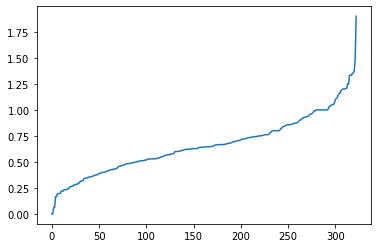

In [35]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2, metric='cityblock')
nbrs = neigh.fit(singapore_grouped_clustering)
distances, indices = nbrs.kneighbors(singapore_grouped_clustering)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

I select eps=1.0 based on the above plot.

In [36]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db = DBSCAN(eps=1.0, min_samples=2, metric='cityblock').fit(singapore_grouped_clustering)
clusterNum = len(set(db.labels_)) 
print('The number of clusters identified by DBSCAN is', clusterNum)

The number of clusters identified by DBSCAN is 5


In [37]:
# add clustering labels
subzone_venues_sorted_labledDB = subzone_venues_sorted
subzone_venues_sorted_labledDB.insert(0, 'Cluster Labels DB',db.labels_)

singapore_mergedDB = singapore_popDf

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
singapore_mergedDB = singapore_mergedDB.join(subzone_venues_sorted_labledDB.set_index('SubZone_Name'), on='SubZone_Name')
singapore_mergedDB.dropna(axis=0, inplace=True)

In [38]:
cluster_counts = singapore_mergedDB.groupby('Cluster Labels DB').count()
cluster_counts['SubZone_Name']

Cluster Labels DB
-1     31
 0    283
 1      5
 2      2
 3      2
Name: SubZone_Name, dtype: int64

In [39]:
# Change the name of the cluster label
singapore_clusters = singapore_mergedDB.groupby('Cluster Labels DB').mean().reset_index()
singapore_clusters.loc[singapore_clusters['Cluster Labels DB']==-1,'Cluster Labels DB'] = 'sing_1'
singapore_clusters.loc[singapore_clusters['Cluster Labels DB']==0,'Cluster Labels DB'] = 'sing_2'
singapore_clusters.loc[singapore_clusters['Cluster Labels DB']==1,'Cluster Labels DB'] = 'sing_3'
singapore_clusters.loc[singapore_clusters['Cluster Labels DB']==2,'Cluster Labels DB'] = 'sing_4'
singapore_clusters.loc[singapore_clusters['Cluster Labels DB']==3,'Cluster Labels DB'] = 'sing_5'
singapore_clusters

,Cluster Labels DB,Resident_Population,Age_(0-19),Age_(20-34),Age_(35-49),Age_(50-64),Age_(65-),HDB_1-2_rooms,HDB_3_rooms,HDB_4_rooms,HDB_5_rooms,Condos,Other_dwelling,Chinese,Malaya,Indian,Other_Ethnicity,SubZoneArea,latitude,longitude,x,y
0,sing_1,2301.935484,0.130108,0.114318,0.147582,0.125587,0.061660,0.049502,0.001197,0.026757,0.011235,0.010336,0.445791,0.450244,0.017558,0.047917,0.066808,6.291423,1.346484,103.837657,28482.769478,36512.975398
1,sing_2,13536.395760,0.152555,0.148639,0.184869,0.161714,0.102493,0.443653,0.030274,0.104220,0.175418,0.133022,0.273048,0.565607,0.066460,0.073758,0.043505,1.949093,1.341981,103.826261,27214.506006,36015.034285
2,sing_3,136.000000,0.043077,0.043077,0.033846,0.049231,0.030769,0.000000,0.000000,0.000000,0.000000,0.000000,0.196923,0.153846,0.003077,0.015385,0.027692,4.724463,1.374888,103.777800,21821.334660,39653.891031
3,sing_4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.585053,1.214684,103.810952,25510.711961,21939.197109
4,sing_5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.262415,1.450702,103.848363,29674.172612,48036.725141


#### Check socio-demographic data    
After having obatined the clusters based on venues data, I check for patterns in the socio-demographic data for each of the clusters.

In [40]:
# Slice dataframe into 3 dataframes based in topic (Age, dwelling, ethnicity):

ageDist = singapore_clusters.iloc[:,[0,2,3,4,5,6]]
ageDist.set_index('Cluster Labels DB', inplace=True, drop=True)

dwellingDist = singapore_clusters.iloc[:,[0,7,8,9,10,11,12]]
dwellingDist.set_index('Cluster Labels DB', inplace=True, drop=True)

ethnicityDist = singapore_clusters.iloc[:,[0,13,14,15,16]]
ethnicityDist.set_index('Cluster Labels DB', inplace=True, drop=True)

I create a function that generates bar charts for each of the sliced dataframes

In [41]:
def createPlots(df,cols,idxname,title):
    plotdf = df.iloc[:,cols]
    plotdf.set_index(idxname, inplace=True, drop=True)
    myPlot = plotdf.plot(kind='bar',  # create bar chart with size and color configuration
                       figsize = (20,8),
                       width = 0.8,
                       color = ('#172CE6', '#FFFF00', '#FF0000', '#00FF09', '#00F7FF', '#00F77F'),
                       fontsize = 14)
    myPlot.set_title(title, fontsize = 16) # set title for plot
    myPlot.legend(fontsize = 14, frameon = True, loc = 'upper right') # set legend, force location and border
    myPlot.spines['top'].set_visible(False)  # get rid of borders around the plot
    myPlot.spines['right'].set_visible(False)
    myPlot.spines['left'].set_visible(False)
    myPlot.yaxis.set_visible(False)  # get rid of y-axis
    # dislay percentages in proper formating on top of each bar
    for p in myPlot.patches:
        myPlot.annotate("{:.1%}".format(p.get_height()),
                    xy=(p.get_x()+0.02, p.get_height()+0.01))
    
    plt.show()

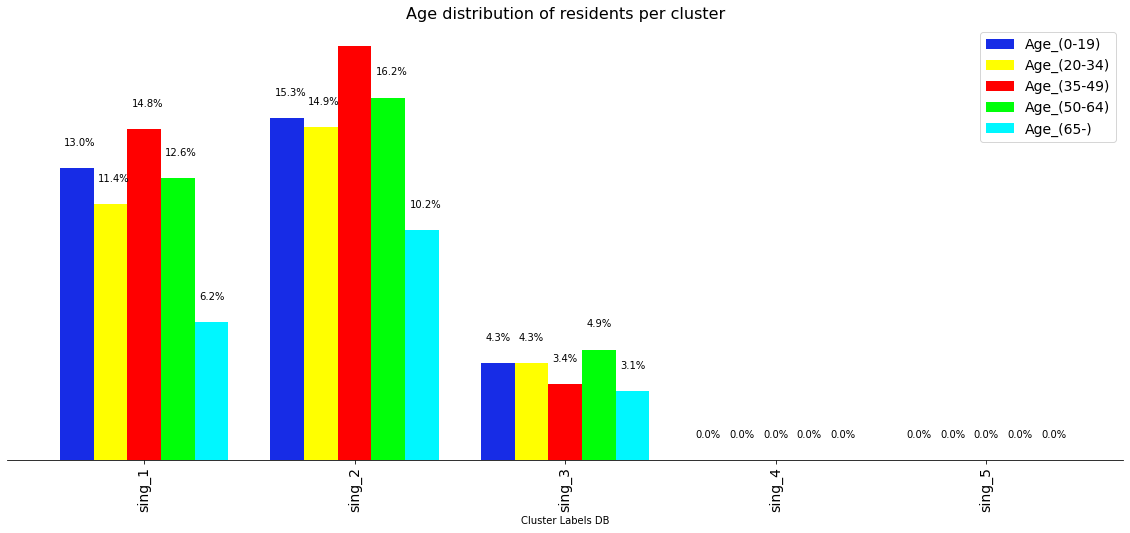

In [42]:
createPlots(singapore_clusters,[0,2,3,4,5,6],'Cluster Labels DB','Age distribution of residents per cluster')

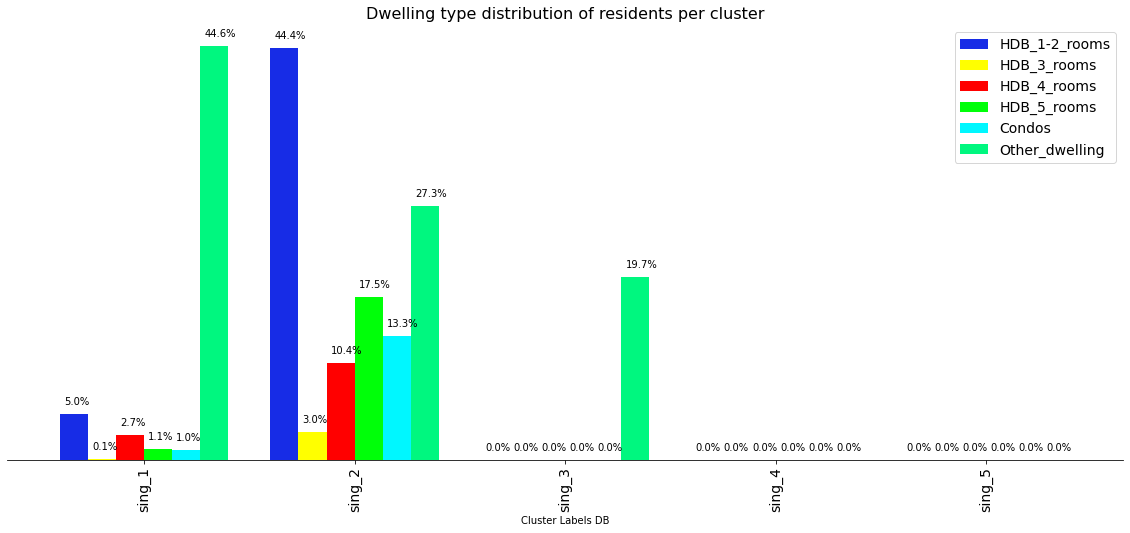

In [43]:
createPlots(singapore_clusters,[0,7,8,9,10,11,12],'Cluster Labels DB','Dwelling type distribution of residents per cluster')

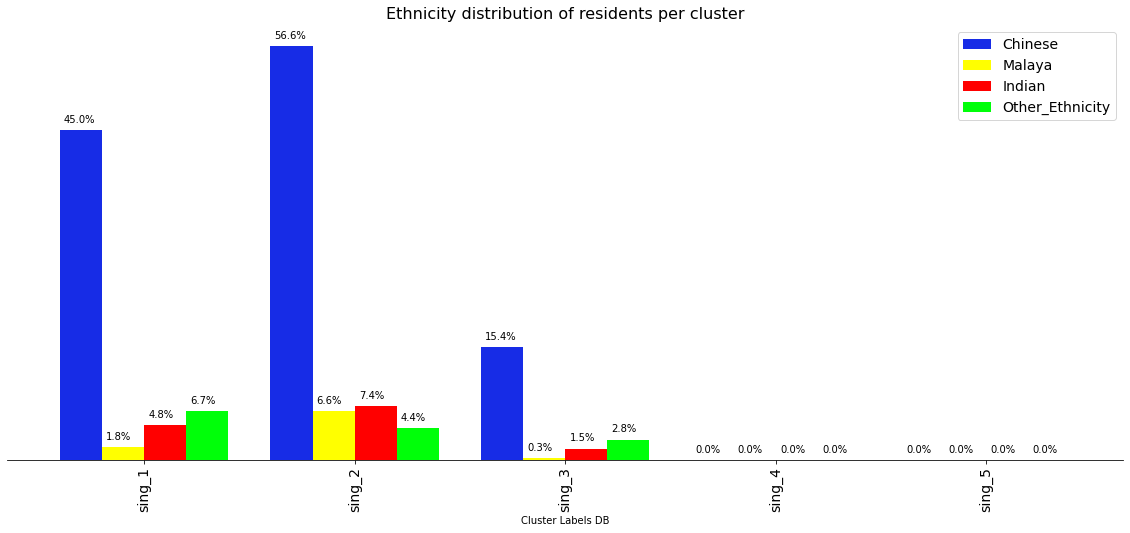

In [44]:
createPlots(singapore_clusters,[0,13,14,15,16],'Cluster Labels DB','Ethnicity distribution of residents per cluster')

Lastly, plot the clusters on a map of Singapore.

In [45]:
# To render the folium map I use the default OpenStreetMaps tile
mySingapore_mapClust = folium.Map(location=singapore_coords, zoom_start=11, control_scale=True, tiles='OpenStreetMap') 

pointColor = {-1: '#172CE6', 0: '#FFFF00', 1: '#FF0000' , 2: '#00FF09', 3: '#00F7FF',4:'#00F77F'}


for lat, lng, subzone, region in zip(singapore_mergedDB['latitude'], singapore_mergedDB['longitude'], singapore_mergedDB['SubZone_Name'], singapore_mergedDB['Cluster Labels DB']):
    label = '{}, {}'.format(subzone, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius = 5,
        popup = label,
        color =  pointColor[region],
        fill = True,
        fill_color = pointColor[region],
        fill_opacity = 0.7,
        parse_html = False).add_to(mySingapore_mapClust)


# Render interactive map including neighborhood locations:
mySingapore_mapClust

Based on the clusters, I create a venues profile for each clusters. This serves to better understand the clusters and as input for the clustering across cities.

In [46]:
# add clustering labels
singapore_grouped_labled = singapore_grouped
singapore_grouped_labled.insert(0, 'Cluster Labels DB',db.labels_)

In [47]:
singapore_grouped_labled.loc[singapore_grouped_labled['Cluster Labels DB']==-1,'Cluster Labels DB'] = 'sing_1'
singapore_grouped_labled.loc[singapore_grouped_labled['Cluster Labels DB']==0,'Cluster Labels DB'] = 'sing_2'
singapore_grouped_labled.loc[singapore_grouped_labled['Cluster Labels DB']==1,'Cluster Labels DB'] = 'sing_3'
singapore_grouped_labled.loc[singapore_grouped_labled['Cluster Labels DB']==2,'Cluster Labels DB'] = 'sing_4'
singapore_grouped_labled.loc[singapore_grouped_labled['Cluster Labels DB']==3,'Cluster Labels DB'] = 'sing_5'

In [48]:
singapore_venues_clean_merged = singapore_venues_clean

singapore_venues_clean_merged = singapore_venues_clean_merged.join(singapore_grouped_labled.set_index('SubZone_Name'), on='SubZone_Name')
singapore_venues_clean_merged.dropna(axis=0, inplace=True)

In [49]:
singapore_grouped_label = getVenueFreq(singapore_venues_clean_merged,'Cluster Labels DB','Venue_Category', False)

In [50]:
singapore_onehot_label, singapore_label_grouped = getVenueFreq(singapore_venues_clean_merged,'Cluster Labels DB','Venue_Category', True)

In [51]:
singapore_label_sorted = getTopVenues(10, 'Cluster Labels DB', singapore_label_grouped)
singapore_label_sorted

,Cluster Labels DB,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,sing_1,Coffee Shop,Public Transport,Shop & Service,Trail,Bar,Chinese Restaurant,Tourist Accommodation,Park,Gym,Seafood Restaurant
1,sing_2,Shop & Service,Coffee Shop,Chinese Restaurant,Food Court,Bar,Japanese Restaurant,Public Transport,Asian Restaurant,Tourist Accommodation,Fast Food Restaurant
2,sing_3,Coffee Shop,Bar,Gym,Food General,Professional & Other Places,Playground,Pizza Place,Food Court,Campground,Brewery
3,sing_4,Other Great Outdoors,Island,Public Transport,Beach,Pier,Tourist Information Center,Exhibit,Factory,Fast Food Restaurant,Filipino Restaurant
4,sing_5,River,Seafood Restaurant,Public Transport,Burger Joint,Coffee Shop,Harbor / Marina,Food Court,Fried Chicken Joint,French Restaurant,Food Truck


The above table provides an overview of the top 10 most common venue categories within each of the clusters.

#### Neighborhoods in New York City

Next, I repeat the previous clusteirng excercise for neighborhoods in New York City. The steps for downloading, preparing, and clustering of neighborhoods and venues data follow the same steps as for Singapore. Therefore, I will add fewer comments.    

Preparing of spatial coordiantes for the New York dataset is simples as the data is provided in an easier to use (compared to the shapefile) geoJSON file and since the coordiantes are already in long, lat format.    

Note that I do not have socio-demographic data comparable to Singapore available for New York City.

In [52]:
with open(r'C:\Users\michael.kurz\Documents\Git_projects\Singapore_Urban_Form\Data\nyu_2451_34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

In [53]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [54]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [55]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [56]:
np.unique(neighborhoods['Borough'])

array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object)

In [57]:
nyc_coords = GetCityCoords('New York City, NY', 'Singapore_App')
print('The geograpical coordinate of New York City are {}, {}.'.format(nyc_coords[0],nyc_coords[1]))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [58]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=nyc_coords, zoom_start=10, control_scale=True)

pointColor = {'Bronx': '#172CE6', 'Brooklyn': '#FFFF00', 'Manhattan': '#FF0000' , 'Queens': '#00FF09', 'Staten Island': '#00F7FF'}

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=pointColor[borough],
        fill=True,
        fill_color=pointColor[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [59]:
venues_list = []
myLimit = 100 # this is the max allowed by the Foursquare API


# loop through all post code areas in the dataset and get Foursquare data for each post code area
for neighbor, boro, lat, lng in zip(neighborhoods['Neighborhood'], neighborhoods['Borough'], neighborhoods['Latitude'], neighborhoods['Longitude']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    fSqure_credentials['CLIENT_ID'],
    fSqure_credentials['CLIENT_SECRET'],
    fSqure_credentials['VERSION'],
    lat,
    lng,
    600,
    myLimit)
    results = requests.get(url).json()
    loc_venue = results['response']['groups'][0]['items']
    venues_list.append([(neighbor,boro, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],v['venue']['categories'][0]['name'],v['venue']['categories'][0]['id']) for v in loc_venue])

nyc_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nyc_venues.columns = ['Neighborhood', 'Borough', 
                  'latitude', 
                  'longitude',
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category',
                  'Venue_Category_ID']

nyc_venues.head()

,Neighborhood,Borough,latitude,longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Venue_Category_ID
0,Wakefield,Bronx,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,4bf58dd8d48988d1d0941735
1,Wakefield,Bronx,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,4bf58dd8d48988d10f951735
2,Wakefield,Bronx,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,4bf58dd8d48988d1c9941735
3,Wakefield,Bronx,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy,4bf58dd8d48988d10f951735
4,Wakefield,Bronx,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,4bf58dd8d48988d148941735


In [60]:
nyc_venues_clean = nyc_venues
nyc_venues_clean = nyc_venues_clean[~nyc_venues_clean['Venue_Category_ID'].isin(dropList)]

In [62]:
for key in venue_lib:
    selection = nyc_venues_clean['Venue_Category_ID'].isin(venue_lib[key])
    nyc_venues_clean.loc[selection,'Venue_Category'] = key

In [85]:
print('The dataframe has {} rows and {} columns.'.format(nyc_venues_clean.shape[0],nyc_venues_clean.shape[1]))
print('There are {} unique venue categories and {} unique venues in the dataframe.'.format(len(nyc_venues_clean['Venue_Category'].unique()),len(singapore_venues_clean['Venue'].unique())))

The dataframe has 12140 rows and 9 columns.
There are 193 unique venue categories and 5924 unique venues in the dataframe.


In [63]:
nyc_onehot, nyc_grouped = getVenueFreq(nyc_venues_clean,'Neighborhood','Venue_Category', True)
nyc_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Arcade,Argentinian Restaurant,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bike Rental / Bike Share,Bike Trail,Bistro,Botanical Garden,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Campground,Caribbean Restaurant,Caucasian Restaurant,Child Care Service,Chinese Restaurant,Circus,Coffee Shop,College & University,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Cruise,Cuban Restaurant,Cultural Center,Czech Restaurant,Daycare,Deli / Bodega,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,English Restaurant,Exhibit,Factory,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Food Court,Food General,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Garden,General Entertainment,German Restaurant,Gluten-free Restaurant,Go Kart Track,Golf,Greek Restaurant,Gym,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Heliport,Himalayan Restaurant,Historic Site,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Mac & Cheese Joint,Malay Restaurant,Medical,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Mountain,Movie Theater,Museum,Music School,Music Venue,Nightclub,Nightlife Spot,Noodle House,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pier,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Professional & Other Places,Public Art,Public Transport,Racetrack,Recreation Center,Rental Car Location,Rest Area,River,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Snack Place,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Spiritual Center,Sports,Sri Lankan Restaurant,State / Provincial Park,Steakhouse,Street Art,Strip Club,Summer Camp,Sushi Restaurant,Swiss Restaurant,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Tibetan Restaurant,Tourist Accommodation,Tourist Information Center,Trail,Turkish Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Waterfront,Yemeni Restaurant
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [84]:
neighborhoods.groupby('Borough').count()

,Neighborhood,Latitude,Longitude
Borough,,,
Bronx,52,52,52
Brooklyn,70,70,70
Manhattan,40,40,40
Queens,81,81,81
Staten Island,63,63,63


In [ ]:
nyc_grouped.groupby()

In [65]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

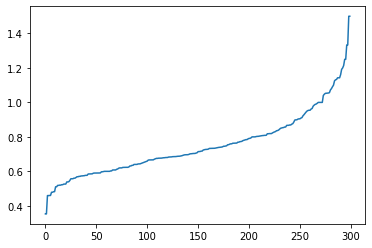

In [66]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2, metric='cityblock')
nbrs = neigh.fit(nyc_grouped_clustering)
distances, indices = nbrs.kneighbors(nyc_grouped_clustering)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [67]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
db_nyc = DBSCAN(eps=1.0, min_samples=2, metric='cityblock').fit(nyc_grouped_clustering)
clusterNum_nyc = len(set(db_nyc.labels_)) 
print('The number of clusters identified by DBSCAN is', clusterNum_nyc)

The number of clusters identified by DBSCAN is 4


In [68]:
# add clustering labels
nyc_grouped_labled = nyc_grouped
nyc_grouped_labled.insert(0, 'Cluster Labels DB',db_nyc.labels_)

In [69]:
nyc_grouped_labled.loc[nyc_grouped_labled['Cluster Labels DB']==-1,'Cluster Labels DB'] = 'nyc_1'
nyc_grouped_labled.loc[nyc_grouped_labled['Cluster Labels DB']==0,'Cluster Labels DB'] = 'nyc_2'
nyc_grouped_labled.loc[nyc_grouped_labled['Cluster Labels DB']==1,'Cluster Labels DB'] = 'nyc_3'
nyc_grouped_labled.loc[nyc_grouped_labled['Cluster Labels DB']==2,'Cluster Labels DB'] = 'nyc_4'

In [81]:
nyc_grouped_labled.groupby('Cluster Labels DB').count()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Arcade,Argentinian Restaurant,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bike Rental / Bike Share,Bike Trail,Bistro,Botanical Garden,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Campground,Caribbean Restaurant,Caucasian Restaurant,Child Care Service,Chinese Restaurant,Circus,Coffee Shop,College & University,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Concert Hall,Cruise,Cuban Restaurant,Cultural Center,Czech Restaurant,Daycare,Deli / Bodega,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,English Restaurant,Exhibit,Factory,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Food Court,Food General,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Garden,General Entertainment,German Restaurant,Gluten-free Restaurant,Go Kart Track,Golf,Greek Restaurant,Gym,Halal Restaurant,Harbor / Marina,Hawaiian Restaurant,Heliport,Himalayan Restaurant,Historic Site,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Mac & Cheese Joint,Malay Restaurant,Medical,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,Mountain,Movie Theater,Museum,Music School,Music Venue,Nightclub,Nightlife Spot,Noodle House,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pier,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Professional & Other Places,Public Art,Public Transport,Racetrack,Recreation Center,Rental Car Location,Rest Area,River,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salvadoran Restaurant,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Snack Place,Social Club,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Spiritual Center,Sports,Sri Lankan Restaurant,State / Provincial Park,Steakhouse,Street Art,Strip Club,Summer Camp,Sushi Restaurant,Swiss Restaurant,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Tibetan Restaurant,Tourist Accommodation,Tourist Information Center,Trail,Turkish Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Waterfront,Yemeni Restaurant
Cluster Labels DB,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nyc_1,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27,27
nyc_2,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,268,2

In [70]:
nyc_venues_clean_merged = nyc_venues_clean

nyc_venues_clean_merged = nyc_venues_clean_merged.join(nyc_grouped_labled.set_index('Neighborhood'), on='Neighborhood')
nyc_venues_clean_merged.dropna(axis=0, inplace=True)

In [71]:
nyc_onehot_label, nyc_label_grouped = getVenueFreq(nyc_venues_clean_merged,'Cluster Labels DB','Venue_Category', True)

In [72]:
nyc_label_sorted = getTopVenues(10, 'Cluster Labels DB', nyc_label_grouped)
nyc_label_sorted

,Cluster Labels DB,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,nyc_1,Beach,Shop & Service,Bar,Tourist Accommodation,Park,Dessert Shop,Thai Restaurant,Pizza Place,Gym,Public Transport
1,nyc_2,Shop & Service,Bar,Gym,Coffee Shop,Pizza Place,Dessert Shop,Italian Restaurant,Deli / Bodega,Chinese Restaurant,Bakery
2,nyc_3,Athletics & Sports,Dessert Shop,Playground,Park,Gym,Harbor / Marina,Mexican Restaurant,Deli / Bodega,Pizza Place,Chinese Restaurant
3,nyc_4,Caribbean Restaurant,Shop & Service,Gym,Music Venue,Pizza Place,Bakery,Thai Restaurant,Dessert Shop,Playground,Chinese Restaurant


The above table shows the top 10 venue categories per cluster in New York City. It represents a cluster profile simialr to the one shown for Singapore.

#### Final step: Cross-city clusters    
In this final step I am creating dendrogram to obatin hierachical connections between the different clusters for Singapore and New York City.

There are some venue categories that only exists in Singapore and some that only exists in New York. Therefore, the dataframes for the two cities have different numbers of columns. I will concat to join the two dataframe without introducting duplicate columns.

In [73]:
nyc_label_grouped.shape

(4, 194)

In [74]:
singapore_label_grouped.shape

(5, 152)

In [75]:
singapore_df = singapore_label_grouped.fillna(value='None')
nyc_df = nyc_label_grouped.fillna(value='None')

two_cities = pd.concat([singapore_df, nyc_df],sort=False).groupby('Cluster Labels DB').last().fillna(value=0.00)

In [76]:
two_cities.shape

(9, 207)

In [77]:
two_cities

,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Bay,Beach,Bike Rental / Bike Share,Bike Trail,Bistro,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burmese Restaurant,Campground,Caribbean Restaurant,Casino,Chinese Restaurant,Coffee Shop,College & University,Comfort Food Restaurant,Concert Hall,Cruise,Deli / Bodega,Dessert Shop,Diner,Dog Run,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant,Exhibit,Factory,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Food Court,Food General,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Garden,General Entertainment,German Restaurant,Gluten-free Restaurant,Go Kart Track,Golf,Greek Restaurant,Gun Range,Gym,Halal Restaurant,Harbor / Marina,Historic Site,Hot Dog Joint,Hot Spring,Hotpot Restaurant,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Island,Italian Restaurant,Japanese Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Malay Restaurant,Medical,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Mountain,Movie Theater,Museum,Music Venue,Nature Preserve,Night Market,Nightclub,Noodle House,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Professional & Other Places,Public Art,Public Transport,Racetrack,Recreation Center,Reservoir,Rest Area,River,Rock Climbing Spot,Roof Deck,Salad Place,Sandwich Place,Satay Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shop & Service,Ski Area,Ski Chalet,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spanish Restaurant,Spiritual Center,Sports,Steakhouse,Sushi Restaurant,Swiss Restaurant,Tea Room,Thai Restaurant,Theme Park,Theme Restaurant,Tourist Accommodation,Tourist Information Center,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Afghan Restaurant,African Restaurant,Animal Shelter,Arts & Entertainment,Austrian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cambodian Restaurant,Caucasian Restaurant,Child Care Service,Circus,Colombian Restaurant,Comedy Club,Cuban Restaurant,Cultural Center,Czech Restaurant,Daycare,Duty-free Shop,Egyptian Restaurant,Falafel Restaurant,Fountain,Hawaiian Restaurant,Heliport,Himalayan Restaurant,Israeli Restaurant,Jewish Restaurant,Lebanese Restaurant,Mac & Cheese Joint,Memorial Site,Mini Golf,Molecular Gastronomy Restaurant,Moroccan Restaurant,Music School,Nightlife Spot,Outdoors & Recreation,Pakistani Restaurant,Pet Café,Poke Place,Polish Restaurant,Rental Car Location,Romanian Restaurant,Russian Restaurant,Salvadoran Restaurant,Social Club,South American Restaurant,Souvlaki Shop,Sri Lankan Restaurant,State / Provincial Park,Street Art,Strip Club,Summer Camp,Tibetan Restaurant,Turkish Restaurant,Varenyky restaurant,Veterinarian,Yemeni Restaurant
Cluster Labels DB,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
nyc_1,0.014409,0.000000,0.002882,0.00000,0.005764,0.023055,0.000000,0.005764,0.014409,0.008646,0.048991,0.000000,0.072046,0.000000,0.000000,0.000000,0.000000,0.005764,0.002882,0.005764,0.002882,0.005764,0.000000,0.000000,0.017291,0.000000,0.017291,0.020173,0.000000,0.000000,0.000000,0.000000,0.025937,0.040346,0.008646,0.005764,0.000000,0.000000,0.002882,0.000000,0.000000,0.000000,0.020173,0.002882,0.000000,0.002882,0.005764,0.020173,0.000000,0.008646,0.000000,0.002882,0.000000,0.002882,0.000000,0.000000,0.000000,0.005764,0.000000,0.000000,0.031700,0.002882,0.002882,0.000000,0.005764,0.0

Given the newly created dataframe, I can now create the dendrogram.

values passed to leaf_label_func
leaves :  [2, 3, 6, 0, 1, 4, 5, 7, 8]


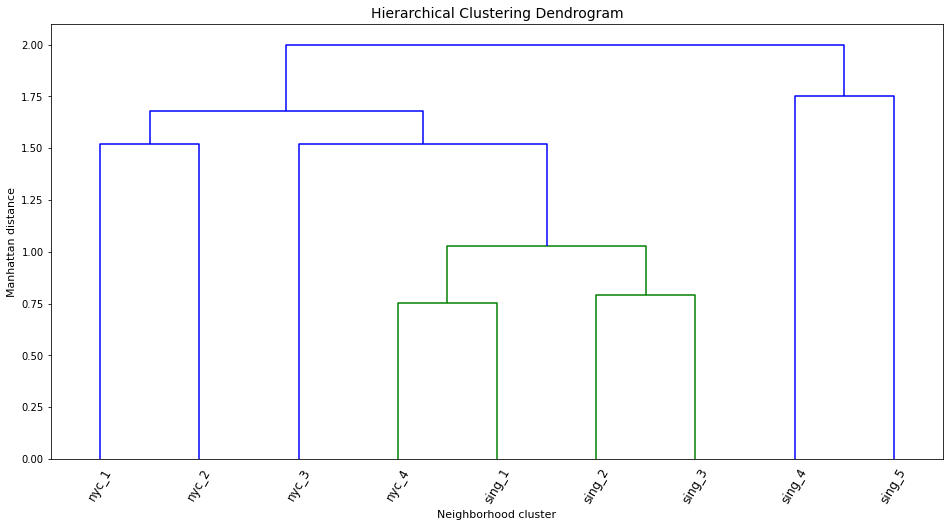

In [78]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(two_cities, metric='cityblock',method='complete')

labels = list(two_cities.index)
p = len(labels)

plt.figure(figsize=(16,8))
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('Neighborhood cluster', fontsize=11)
plt.ylabel('Manhattan distance', fontsize=11)

# call dendrogram to get the returned dictionary 
# (plotting parameters can be ignored at this point)
R = dendrogram(
                Z,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=p,  # show only the last p merged clusters
                no_plot=True,
                )

print("values passed to leaf_label_func\nleaves : ", R["leaves"])
# create a label dictionary
temp = {R["leaves"][ii]: labels[ii] for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{}".format(temp[xx])

dendrogram(
            Z,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=p,  # show only the last p merged clusters
            leaf_label_func=llf,
            leaf_rotation=60.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
            )
plt.show()

### Discussion   

The results of the clustering reveal a striking similarity of neighborhoods within both cities Singapore and New York. For both cities, most neighborhoods are grouped into a single cluster. This implies that for both cities most neighborhoods offer rather similar types of amenities. Also, for both cities, the second largest clusters are the low-density clusters, i.e. clusters with too little similarity to each other or to other neighborhoods to be grouped into any of the other clusters. The similarity in results is remarkable given Singapore and New York are situated in very different cultural environments and look back at a very different history. On the other hand, both cities are financial and cultural centers, focal points of global trade and commerce, and multi-cultural melting pots. Similar patterns in terms of the cluster results seem to suggest latter influence outweigh history and regional culture. This provides potentially interesting insights for urban planners but also expatriates relocating from one city to the other. In many aspects, Singapore and New York seem rather similar and especially similarities of neighborhoods within each city are high. For Urban planners this implies branding of neighborhoods in terms of amenities seems less meaningful for most neighborhoods. The unique profile of neighborhoods could be sharped by encouraging greater diversity in venues. Expatriates can expect significant differences across cities but location choices within cities seem less important as far as the availability and diversity of amenities are concerned.    

However, the results presented in this report should be only preliminary. Future research should be conducted to solidify the evidence presented here. More detailed data on venues such as price ranges, visitor ratings, and frequency of visitor check-ins should be considered. I left these additional data items out of scope for the current analysis since they subject to a stricter download volume limit for free accounts in Foursquare API. Therefore, downloading them within a reasonable timeframe for all venues in two major cities was not feasible.    